In [1]:
import scipy.io as sio
import numpy as np
from copy import deepcopy
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from scipy.special import erf
from mpl_toolkits.mplot3d import Axes3D
import cmath
import matplotlib
font = {'size'   : 15}
matplotlib.rc('font', **font)
import fejer_kernel
import fourier_filter
import generate_cdf

In [3]:
# Prepare data #
data = sio.loadmat('Ising_L_8g_4.mat')
p0=float(data['E0'])
eigenenergies=np.array(data['eigenvalue'])
def generate_spectrum_overlap(p0):
    spectrum = eigenenergies *np.pi/np.max(np.abs(eigenenergies))/3*(1+np.random.uniform(0,1))
    q = np.random.uniform(0,1,len(eigenenergies))
    q[0] = 1.0
    q /= np.sum(q)
    p = (1-p0)/(1-q[0])*q
    p[0] = p0
    return spectrum, p

KeyError: 'eigenvalue'

In [3]:
def generate_QPE_distribution(spectrum,overlap,J):
    N = len(spectrum)
    dist = np.zeros(J)
    j_arr = 2*np.pi*np.arange(J)/J - np.pi
    for k in range(N):
        dist += overlap[k] * fejer_kernel.eval_Fejer_kernel(J,j_arr-spectrum[k])/J
    return dist

In [4]:
def generate_estimation_QCELS(spectrum,overlap,t,Ns):
    Re=0
    Im=0
    z=np.dot(overlap,np.exp(1j*spectrum*t))
    Re_true=(1+z.real)/2
    Im_true=(1+z.imag)/2
    for nt in range(Ns):
        if np.random.uniform(0,1)<Re_true:
           Re+=1
    for nt2 in range(Ns):
        if np.random.uniform(0,1)<Im_true:
           Im+=1
    return complex(2*Re/Ns-1,2*Im/Ns-1)
       

In [5]:
p0_array=np.array([0.6,0.8])#overlap
T0 = 100
N_test_QCELS=20#number of QCELS test
N_QPE=20#number of QPE test
T_list_QCELS = 100+T0/2*(np.arange(N_test_QCELS))
T_list_QPE = 100+T0*4*(np.arange(N_QPE))
err_QCELS=np.zeros((len(p0_array),len(T_list_QCELS)))
err_QPE=np.zeros((len(p0_array),len(T_list_QPE)))
cost_list_avg_QCELS = np.zeros((len(p0_array),len(T_list_QCELS)))
cost_list_avg_QPE = np.zeros((len(p0_array),len(T_list_QPE)))
rate_success_QCELS=np.zeros((len(p0_array),len(T_list_QCELS)))
rate_success_QPE=np.zeros((len(p0_array),len(T_list_QPE)))
Navg = 20#number of trying
err_thres_hold=0.1
err_thres_hold_QPE=0.1
#-----------------------------    
for a1 in range(len(p0_array)):
     p0=p0_array[a1]
     n_success_QCELS= np.zeros(len(T_list_QCELS))
     n_success_QPE= np.zeros(len(T_list_QPE))
     for n_test in range(Navg):
         print("For p0=",p0,"For N_test=",n_test+1)
         spectrum, overlap = generate_spectrum_overlap(p0)
         #------------------QCELS-----------------
         NT=5 #number of time cut
         Ns=40 #cost to control noise
         for ix in range(len(T_list_QCELS)):
             T = T_list_QCELS[ix]
             tau=T/NT
             N=int(np.log2(tau))
             ovlp=np.zeros(NT,dtype = 'complex_')
             tau=T/NT/(2**(N))
             ts=tau*np.arange(NT)
             for i in range(NT):
                  ovlp[i]=generate_estimation_QCELS(spectrum,overlap,ts[i],Ns)
             def fun(x):
                 signal=np.zeros(NT,dtype = 'complex_')
                 for i in range(NT):
                     signal[i]=(x[0]+1j*x[1])*np.exp(1j*x[2]*ts[i])
                 return (np.linalg.norm(signal-ovlp)/NT)
             lambda_prior=spectrum[0]+np.random.uniform(-1,1)*np.pi/(tau*NT)
             x0=np.array([0.5,0,lambda_prior],dtype=object)
             res=minimize(fun,x0,method='SLSQP')
             ground_coefficient_QCELS=res.x[0]
             ground_coefficient_QCELS2=res.x[1]
             ground_energy_estimate_QCELS=res.x[2]
             lambda_min=ground_energy_estimate_QCELS-np.pi/(2*tau)
             lambda_max=ground_energy_estimate_QCELS+np.pi/(2*tau)
             for n_QCELS in range(N):
                 ovlp=np.zeros(NT,dtype = 'complex_')
                 tau=T/NT/(2**(N-n_QCELS-1))
                 ts=tau*np.arange(NT)
                 for i in range(NT):
                     ovlp[i]=generate_estimation_QCELS(spectrum,overlap,ts[i],Ns)
                 def fun(x):
                     signal=np.zeros(NT,dtype = 'complex_')
                     for i in range(NT):
                         signal[i]=(x[0]+1j*x[1])*np.exp(1j*x[2]*ts[i])
                     return (np.linalg.norm(signal-ovlp)/NT)
                 x0=np.array((ground_coefficient_QCELS,ground_coefficient_QCELS2,ground_energy_estimate_QCELS))
                 bnds=((-np.inf,np.inf),(-np.inf,np.inf),(lambda_min,lambda_max))
                 res=minimize(fun,x0,method='SLSQP',bounds=bnds)
                 ground_coefficient_QCELS=res.x[0]
                 ground_coefficient_QCELS2=res.x[1]
                 ground_energy_estimate_QCELS=res.x[2]
                 lambda_min=ground_energy_estimate_QCELS-np.pi/(2*tau)
                 lambda_max=ground_energy_estimate_QCELS+np.pi/(2*tau)
             err_this_run_QCELS = np.abs(ground_energy_estimate_QCELS-spectrum[0])
             err_QCELS[a1,ix] = err_QCELS[a1,ix]+np.abs(err_this_run_QCELS)
             if np.abs(err_this_run_QCELS)<err_thres_hold:
                n_success_QCELS[ix]+=1
             cost_list_avg_QCELS[a1,ix] = T*(NT-1)*Ns
        # ----------------- QPE -----------------------
         N_try_QPE=30
         for ix in range(len(T_list_QPE)):
             T = int(T_list_QPE[ix])
             discrete_energies = 2*np.pi*np.arange(T)/T - np.pi
             spectrum, overlap = generate_spectrum_overlap(p0)
             dist = generate_QPE_distribution(spectrum,overlap,T)
             samp = generate_cdf.draw_with_prob(dist,N_try_QPE)
             j_min = samp.min()
             ground_energy_estimate_QPE = discrete_energies[j_min]
             err_this_run_QPE = np.abs(ground_energy_estimate_QPE-spectrum[0])
             err_QPE[a1,ix] = err_QPE[a1,ix]+np.abs(err_this_run_QPE)
             if np.abs(err_this_run_QPE)<err_thres_hold_QPE:
                n_success_QPE[ix]+=1
             cost_list_avg_QPE[a1,ix] = T*N_try_QPE
     rate_success_QCELS[a1,:] = n_success_QCELS[:]/Navg
     rate_success_QPE[a1,:] = n_success_QPE[:]/Navg
     err_QPE[a1,:] = err_QPE[a1,:]/Navg
     err_QCELS[a1,:] = err_QCELS[a1,:]/Navg

For p0= 0.6 For N_test= 1
For p0= 0.6 For N_test= 2
For p0= 0.6 For N_test= 3
For p0= 0.6 For N_test= 4
For p0= 0.6 For N_test= 5
For p0= 0.6 For N_test= 6
For p0= 0.6 For N_test= 7
For p0= 0.6 For N_test= 8
For p0= 0.6 For N_test= 9
For p0= 0.6 For N_test= 10
For p0= 0.6 For N_test= 11
For p0= 0.6 For N_test= 12
For p0= 0.6 For N_test= 13
For p0= 0.6 For N_test= 14
For p0= 0.6 For N_test= 15
For p0= 0.6 For N_test= 16
For p0= 0.6 For N_test= 17
For p0= 0.6 For N_test= 18
For p0= 0.6 For N_test= 19
For p0= 0.6 For N_test= 20
For p0= 0.8 For N_test= 1
For p0= 0.8 For N_test= 2
For p0= 0.8 For N_test= 3
For p0= 0.8 For N_test= 4
For p0= 0.8 For N_test= 5
For p0= 0.8 For N_test= 6
For p0= 0.8 For N_test= 7
For p0= 0.8 For N_test= 8
For p0= 0.8 For N_test= 9
For p0= 0.8 For N_test= 10
For p0= 0.8 For N_test= 11
For p0= 0.8 For N_test= 12
For p0= 0.8 For N_test= 13
For p0= 0.8 For N_test= 14
For p0= 0.8 For N_test= 15
For p0= 0.8 For N_test= 16
For p0= 0.8 For N_test= 17
For p0= 0.8 For N_t

QCELS
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
QPE
[[0.7  0.8  0.85 1.   1.   1.   1.   1.   0.95 1.   1.   1.   1.   1.
  0.95 1.   1.   1.   1.   1.  ]
 [0.55 0.85 0.9  0.95 1.   1.   1.   0.95 1.   1.   1.   0.95 1.   1.
  1.   1.   1.   0.95 1.   1.  ]]


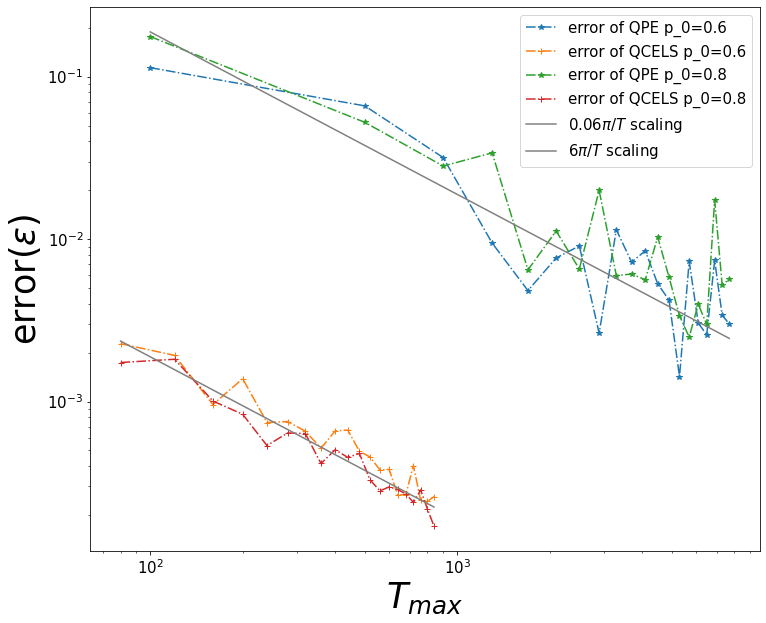

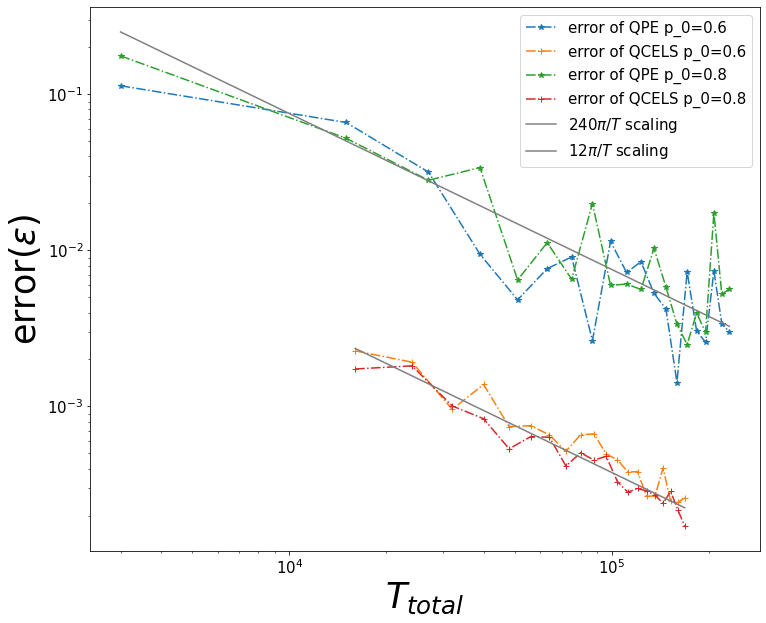

In [7]:
print('QCELS')
print(rate_success_QCELS)
print('QPE')
print(rate_success_QPE)
plt.figure(figsize=(12,10))
plt.plot(T_list_QPE,err_QPE[0,:],linestyle="-.",marker="*",label="error of QPE p_0=0.6")
plt.plot(T_list_QCELS*(NT-1)/(NT),err_QCELS[0,:],linestyle="-.",marker="+",label="error of QCELS p_0=0.6")
plt.plot(T_list_QPE,err_QPE[1,:],linestyle="-.",marker="*",label="error of QPE p_0=0.8")
plt.plot(T_list_QCELS*(NT-1)/(NT),err_QCELS[1,:],linestyle="-.",marker="+",label="error of QCELS p_0=0.8")
plt.plot(T_list_QCELS*(NT-1)/(NT),0.06*np.pi/(T_list_QCELS*(NT-1)/(NT)),linestyle="-",color="grey",label="$0.06\pi/T$ scaling")
plt.plot(T_list_QPE,6*np.pi/T_list_QPE,linestyle="-",color="grey",label="$6\pi/T$ scaling")
plt.xlabel("$T_{max}$",fontsize=35)
plt.ylabel("error($\epsilon$)",fontsize=35)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.savefig('Ising model_depth_256.pdf')
plt.figure(figsize=(12,10))
plt.plot(cost_list_avg_QPE[0,:],err_QPE[0,:],linestyle="-.",marker="*",label="error of QPE p_0=0.6")
plt.plot(cost_list_avg_QCELS[0,:],err_QCELS[0,:],linestyle="-.",marker="+",label="error of QCELS p_0=0.6")
plt.plot(cost_list_avg_QPE[1,:],err_QPE[1,:],linestyle="-.",marker="*",label="error of QPE p_0=0.8")
plt.plot(cost_list_avg_QCELS[1,:],err_QCELS[1,:],linestyle="-.",marker="+",label="error of QCELS p_0=0.8")
plt.plot(cost_list_avg_QPE[1,:],240*np.pi/cost_list_avg_QPE[1,:],linestyle="-",color="grey",label="$240\pi/T$ scaling")
plt.plot(cost_list_avg_QCELS[1,:],12*np.pi/cost_list_avg_QCELS[1,:],linestyle="-",color="grey",label="$12\pi/T$ scaling")
plt.xlabel("$T_{total}$",fontsize=35)
plt.ylabel("error($\epsilon$)",fontsize=35)  
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.savefig('Ising model_cost_256.pdf')

In [ ]:
 ### random test
 NT=300
 Ns=50
 tau=0.1
 dim=256
 p0=0.8
 overlap = generate_overlap(p0,dim) 
 ts=tau*np.arange(NT)
 ovlp=np.zeros(NT,dtype = 'complex_')
 Re_data=np.zeros(NT)
 Im_data=np.zeros(NT)
 Re_approx=np.zeros(NT)
 Im_approx=np.zeros(NT)
 Re_true=np.zeros(NT)
 Im_true=np.zeros(NT)
 spectrum_test=generate_spectrum(0.15,dim)
 for i in range(NT):
     ovlp[i]=generate_estimation_QCELS(spectrum_test,overlap,ts[i],Ns)
     data=generate_estimation_QCELS(spectrum_test,overlap,ts[i],Ns)
     Re_data[i]=data.real
     Im_data[i]=data.imag
 def fun(x):
     signal=np.zeros(NT,dtype = 'complex_')
     for i in range(NT):
         signal[i]=(x[0]+1j*x[1])*np.exp(1j*x[2]*ts[i])
     return (np.linalg.norm(signal-ovlp)/NT)
 x0=np.array((0.8,0,spectrum_test[0]))
 res=minimize(fun,x0,method='SLSQP')
 ground_coefficient_QCELS=res.x[0]
 ground_coefficient_QCELS2=res.x[1]
 ground_energy_estimate_QCELS=res.x[2]
 print(ground_energy_estimate_QCELS)
 print(ground_coefficient_QCELS+1j*ground_coefficient_QCELS2)
 print(spectrum_test[0])
 for i in range(NT):
     signal=(ground_coefficient_QCELS+1j*ground_coefficient_QCELS2)*np.exp(1j*ground_energy_estimate_QCELS*ts[i])
     Re_approx[i]=signal.real
     Im_approx[i]=signal.imag
     Solu=0.8*np.exp(1j*spectrum_test[0]*ts[i])
     Re_true[i]=Solu.real
     Im_true[i]=Solu.imag
 fig=plt.figure(figsize=(12,10))
 ax=Axes3D(fig)
 ax.scatter3D(ts,Re_data,Im_data,label="Data")
 ax.plot3D(ts,Re_approx,Im_approx,label="Approximation",color='red')
 ax.set_zticks(np.arange(-1, 1, 0.5))
 ax.tick_params(axis='z',labelsize=15)
 ax.set_yticks(np.arange(-1, 1, 0.5))
 ax.tick_params(axis='y',labelsize=15)
 ax.tick_params(axis='x',labelsize=15)
 ax.set_zlabel('Imaginary part',fontsize=30,labelpad=16) 
 ax.set_ylabel('Real part',fontsize=30,labelpad=16) 
 ax.set_xlabel('Time t',fontsize=30,labelpad=16) 
 plt.savefig('Approximation.pdf')
 plt.legend()